# Support identification: TSOC vs GR

Compressed Sensing (CS) is based on the hypothesis that the input is sparse in some domain, where with sparse we mean a signals whose components are mostly null and only a small minority is different from zero. However, real-world signals are hardly ever sparse due to different reasons as for example the presence of noise in acquisition. Hence, signals cannot be considered sparse but **compressible**, i.e., most components are negligible compared with a small minority which have a significantly higher magnitude.

In the literature, there exist a family of CS decoders [[1]](#TBCAS2020) which reconstruct the input from the mesurement by leveraging the knowledge of the **support** which indicates the position of the non-null coefficients in the sparse representation of the input. 

However, we can define a signal support only when the signal is sparse. In [[2]](#JETCAS2020), we extended the definition of support to compressible signals as the support that, given a CS encoder, maximizes the quality of reconstruction. This definition of support for compressible signals has the disadvantage to depend on how the signal is compressed into measurements, i.e., it depends on the CS encoder.

Recently, we explored the possibility to define a support of a compressible signal independetly from encoding. The idea consists in considering the components with highest magnitude that retain a certain fraction of energy $\eta$. We call this method GR (intials of Gabriele Ravaglia, the student who worked on this first)

This notebook aims to compare the TSOC method (the one proposed in [[2]](#JETCAS2020)) to the recently considered GR method. We expect the former to outperform the latter but depending on the differences there may be cases in which the GR method is preferrable.


In [5]:
%matplotlib widget

In [6]:
%%html
<style>
.cell-output-ipywidget-background {
   background-color: transparent !important;
}
.jp-OutputArea-output {
   background-color: transparent;
}  
</style>

In [7]:
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import neurokit2 as nk

import multiprocessing as mp

from itertools import product

from scipy import linalg
from numpy import random

from tqdm import tqdm

from synthetic_ecg import load_synthetic_ecg
from wavelet_basis import wavelet_basis
from utils import add_noise, compute_rsnr
from compressed_sensing import CompressedSensing, generate_sensing_matrix


## Dataset

We use a synthetic Electrocardiography (ECG) dataset, the same employed in [[1]](#TBCAS2020) and [[2]](#JETCAS2020). The dataset has been generated with [ECGSYN](https://physionet.org/content/ecgsyn/1.0.0/) (which implements the algorithm reported in [[3]](#McSharry_TBME2003)).

The heart-beat rate is randomly set using an uniform distribution between 60 and 100 beat/minute. We generate chunks of 2s with a 256sample/s sampling frequency, that are split into windows
of n subsequent samples.

In [8]:
# path to store data such as generated ECG, supports and RSNR values
data_folder = '/srv/newpenny/dnn-cs/tsoc/data/'
if not os.path.exists(data_folder):
    os.mkdir(data_folder)

In [9]:
n = 128
ecg_seed = 0

ecg = load_synthetic_ecg(sample_dimension=n, seed=ecg_seed)

As in [[1]](#TBCAS2020) and [[2]](#JETCAS2020) and firstly proposed in [[4]](#TBCAS2015), we employ the Symmlet-6 family of the orthogonal Wavelet functions as a Sparsity basis.

In [10]:
basis = 'sym6'

D = wavelet_basis(n, basis, level=2)

## GR Algorithm

Identify signal support with GR algortithm which identify the support by considering the smallest subsets of compontest that retains a given energy fraction.

In [11]:
def find_support_GR(x, D, eta=0.99):
    '''
    Identify signal support with GR algortithm which identify the support by
    considering the smallest subsets of compontest that retains a given 
    energy fraction.

    Parameters
    ----------
    x: (n, ) numpy.ndarray,
        input signal
    D: (n, n) numpy.ndarray,
        sparsity basis
    eta: float, optional (default 0.99)
        energy fraction retained by the components selected by the support.

    Returns
    -------
    (n, ) numpy.ndarray,
        support of the input x.
    '''

    xi = D.T @ x  # sparse representation of the input

    xi2 = xi**2
    xi2 = xi2 / np.sum(xi2) # input squared and normalized to unit-energy

    i_sort = np.argsort(xi2)[::-1]  # sort components in descending order
    # index of the smallest component in the support
    i_th = np.argmax(np.cumsum(xi2[i_sort]) > eta)
    th = xi2[i_sort[i_th]]  # magnitude of the smallest component in the support
    # support as all components greater or equal the smallest in the support
    z = xi2 >= th

    return z

### Experiments

The experiments measure the Resconstruction Signal to Ratio (RSNR) in different settings. Different settings involve:
- data: the amount of noise injected into the synthetic ECG signal
- support identification method: the amount of energy fraction used to determine the support
- compressed sensing system: the amount of measurements (`m`), the type of encoder (standard or rakeness-based), and whether the sensing matrix is orthogonalized or not.

In [12]:
# Experiment parameters

# ---- data ----
isnr_list = (30., 35., 40., 45.)  # Intrinsic Signal-to-Noise Ratio

# ---- support ---- 
method = 'GR' # support identification algorithm
eta_list = (
    0.9, 
    0.93,    0.95,    0.97,    0.98,    0.985,    0.99, 
    0.993,   0.995,   0.997,   0.998,   0.9985,   0.999, 
    0.9993,  0.9995,  0.9997,  0.9998,  0.99985,  0.9999, 
    0.99993, 0.99995, 0.99997, 0.99998, 0.999985, 0.99999,
)  # energy fractions

# ---- compressed sensing ---- 
m_list = (16, 32, 48, 64)  # number of measurements
mode = 'standard'  # CS mode: standard, rakeness
orth = True  # whether orthogonalize sensing matrix or not

The experiments are conducted through the script `compute_rsnr_GR.py`. Here we load and visulize the results.

In [13]:
rsnr = []
for isnr in isnr_list:
    folder = os.path.join(
        data_folder, f'seed={ecg_seed}_n={n}_basis={basis}_isnr={isnr}')
    rsnr_path = os.path.join(folder, f'rsnr_method={method}.pkl')
    tmp = pd.read_pickle(rsnr_path)
    tmp = tmp.xs((mode, orth), level=('mode', 'orth'), axis=1)
    tmp = tmp.reindex(columns=eta_list, level='eta')
    tmp = tmp.reindex(columns=m_list, level='m')
    tmp = pd.concat(
        [tmp], axis=1, keys=[isnr], names=['isnr'] + tmp.columns.names)
    rsnr.append(tmp)
rsnr = pd.concat(rsnr, axis=1)
rsnr

isnr         30.0                                                         \
m              16                                                          
seed            0                                                          
eta      0.900000   0.930000   0.950000   0.970000   0.980000   0.985000   
0        7.458986   8.506868   9.617219   8.569460  11.299529  11.763529   
1       12.390687  12.390687  13.657444  15.373086  17.088725  17.088725   
2        7.505573   8.949696  10.575608  11.450585  14.080870  14.080870   
3        7.152996   7.152996  12.001728  11.059022  11.698879   9.034440   
4        9.275902  11.159826  11.159826  10.436961  10.436961  11.231498   
...           ...        ...        ...        ...        ...        ...   
199995   8.919544   9.600219   9.600219  14.627131  14.627131  16.088170   
199996   7.778103  11.139430  10.814410   8.253493  10.797400   8.593536   
199997   9.226825  10.846350  12.204687  14.191702  14.621249  15.594931   
199998  12.339394  12.339394  13.644655  15.934821  17.352751  17.352751   
199999  10.400567  13.469178  13.469178  15.438742  15.438742  15.438742   

isnr                                                ...       45.0             \
m                                                   ...         64              
seed                                                ...          7              
eta      0.990000   0.993000   0.995000   0.997000  ...   0.999700   0.999800   
0        8.606043  11.139651  16.924462   4.970408  ...  34.711032  36.552856   
1       13.234376  13.096705  12.654368  13.611357  ...  34.276051  36.112288   
2       14.527044  15.969701 -10.641067  -8.863915  ...  34.551864  35.769581   
3        8.713747   7.359802   6.809012   7.160654  ...  34.538222  36.650524   
4        4.520895   4.620814 -10.821528  10.410513  ...  34.484052  35.392468   
...           ...        ...        ...        ...  ...        ...        ...   
199995  16.861903  18.248324  18.619463  17.649457  ...  35.401819  37.421612   
199996   8.702486   2.107146   2.153827  12.215798  ...  36.434170  36.434170   
199997  18.083778  18.202849   8.824030  15.057338  ...  34.261202  35.777072   
199998  19.920609  20.104079  20.019912  21.875422  ...  35.521041  36.515797   
199999  18.640254  18.640254  18.976800  21.602061  ...  34.709313  36.265799   

isnr                                                                      \
m                                                                          
seed                                                                       
eta      0.999850   0.999900   0.999930   0.999950   0.999970   0.999980   
0       36.663685  39.009147  40.209061  41.611978  43.729225  43.660505   
1       36.944595  38.835783  39.800791  40.818038  37.844026  24.567734   
2       37.087215  40.216564  41.301756  41.614952  43.375494  44.983315   
3       37.074936  37.975511  39.922070  40.825210  43.156532  43.103644   
4       37.696605  39.000471  40.385755  41.422385  42.306808  40.932726   
...           ...        ...        ...        ...        ...        ...   
199995  37.787092  39.288281  39.906878  41.760161  41.957478  41.295261   
199996  37.447017  39.359011  40.133767  41.252798  43.200193  44.579503   
199997  37.126449  38.531553  39.397396  40.551895  42.416649  41.067096   
199998  38.127962  39.982475  40.940519  41.844445  42.325248  42.865791   
199999  38.067974  39.591836  40.776536  42.335975  43.926601  43.708094   

isnr                          
m                             
seed                          
eta      0.999985   0.999990  
0       42.734106  43.641104  
1       14.008822   9.596215  
2       46.071453  47.515780  
3       42.607338  43.963008  
4       40.808894  37.001007  
...           ...        ...  
199995  39.355322  30.018797  
199996  44.847338  42.506143  
199997  40.346783  29.529652  
199998  42.244778  25.259317  
199999  43.864961  44.132825  

[200000 rows x 3160 columns]

In [14]:
# compute statistics
_rsnr = rsnr.stack('seed')
rsnr_med = _rsnr.median().unstack(('isnr', 'm'))
rsnr_q25 = _rsnr.quantile(.25).unstack(('isnr', 'm'))
rsnr_q75 = _rsnr.quantile(.75).unstack(('isnr', 'm'))
eta_best = rsnr_med.idxmax()

isnr,30.0,35.0,40.0,45.0
m,,,,
16,13.631387,14.052606,14.168555,14.206906
32,23.306889,26.153121,28.513203,30.126712
48,27.551202,31.405733,35.228282,38.559454
64,30.132822,34.593364,38.837619,42.845470


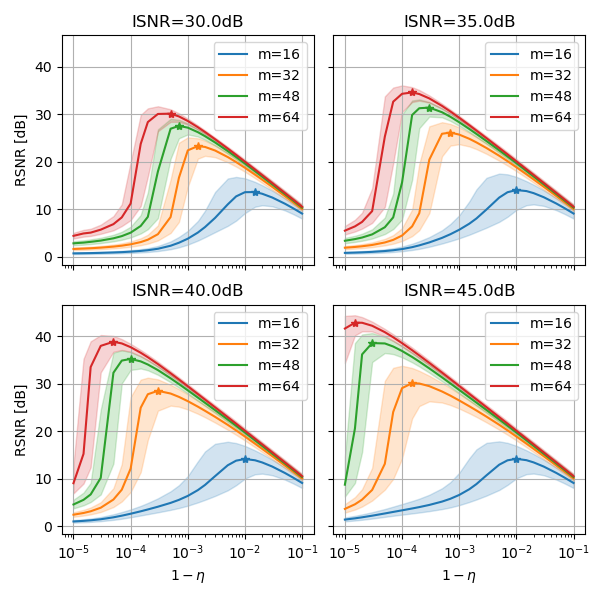

In [15]:
ncols = min(int(np.sqrt(np.floor(len(isnr_list)))), 4)
nrows = len(isnr_list) // ncols

fig, axs = plt.subplots(nrows, ncols, figsize=(6, 3*nrows), 
                        sharex='all', sharey='all', squeeze=False)
index = 1 - rsnr_med.index

for ax, isnr in zip(axs.flatten(), isnr_list):
    for i, m in enumerate(rsnr_med[isnr].columns):
        ax.plot(index, rsnr_med[isnr, m], label=f'm={m}')
        ax.fill_between(index, rsnr_q25[isnr, m], rsnr_q75[isnr, m], 
                        color=f'C{i}', alpha=0.2)
        ax.plot([1 - eta_best[isnr, m]], [rsnr_med.max()[isnr, m]], 
                marker='*', color=f'C{i}')
    ax.set(xscale='log')
    ax.set(title=f'ISNR={isnr}dB')
    ax.grid()
    ax.legend()
for ax in axs[:, 0]: ax.set(ylabel='RSNR [dB]')
for ax in axs[-1]: ax.set(xlabel='$1-\eta$')

fig.tight_layout()
rsnr_med.max().unstack('isnr')


- the higher the number of mesurements `m` (i.e., lower the compression ratio) the higher the energy fraction $\eta$ that gives the best performance. This is intuitive as a higher compression leaves less room for components.

- As the noise energy increases (lower ISNR), the lower the the energy fraction $\eta$ that gives the best performance. This behavior is expected as with a higher noise swallows more components so that a fewer number contributes for the signal reconstruction.


## TSOC Algorithm

Identify signal support with TSOC algortithm which identify the support as the one maximizing the quality of reconstruction.

In [16]:
def find_support_TSOC(x, cs):
    '''
    Identify signal support with TSOC algortithm which identify the support as 
    the one maximizing the quality of reconstruction.

    Parameters
    ----------
    x: (n, ) numpy.ndarray,
        input signal
    cs: CompressedSensing,
        compressed sensing system

    Returns
    -------
    (n, ) numpy.ndarray,
        support of the input x.
    '''
    
    y = cs.encode(x)  # measurements
    xi = cs.D.T @ x   # sparse representation of the input

    # empty support that is filled one element at every iteration
    z = np.zeros(cs.n, dtype=bool)
    # indexes of xi sorted by magnitude in descending order
    argsort_xi = np.argsort(np.abs(xi))[::-1] 
    rsnr = np.empty(cs.m, dtype=float)  # stores rsnr at each iteration
    for i in range(cs.m):
        z[argsort_xi[i]] = True  # include element in the support
        # compute reconstructed signal by pseudo-inversion 
        x_hat = y @ linalg.pinv(cs.B[:, z]).T @ cs.D[:, z].T
        rsnr[i] = compute_rsnr(x, x_hat)
    k = 1 + np.argmax(rsnr) # number of components to include in the support

    # build best support
    z = np.zeros(cs.n, dtype=bool)
    z[argsort_xi[:k]] = True

    return z

### working principle

TSOC algorithm is a greedy algorithm that finds a proxy of the support that maximizes the RSNR. 

The algorithm is iterative and builds the support considering one component at a time ordered from the highest to lowest magnitude up to the `m`-th components, where `m` is the number of measurements (i.e., the dimension of the compressed signal `y`). At each iteration, the algorithms includes a new component, reconstructs the input signal, and measures the quality in terms of RSNR. 

Following the iterative procedure, the algorithm selects the support as the one that gave the highest RSNR.

Here, we show how TSOC algorithm finds the support `s` of a signal `x` for different values of `m` (number of measurements) and sensing matrices `A` generated with different seeds.

In [17]:
i_sample = 0  # index of the ECG sample
isnr = 35  # Intrinsic SNR [dB]
m_list = (16, 32, 48, 64)
seed_list = np.arange(100)

# add noise to ECG sample
x = add_noise(ecg[i_sample], isnr, seed=ecg_seed)

rsnr = pd.DataFrame(
    index=1 + np.arange(max(m_list)),
    columns=pd.MultiIndex.from_product(
        (m_list, seed_list), names=('m', 'seed')),
    dtype=float,
)
for seed in tqdm(seed_list):

    A = generate_sensing_matrix((np.max(m_list), n), seed=seed)

    for m in m_list:
        # find and sort sparse representation of x
        xi = D.T @ x
        argsort_xi = np.argsort(np.abs(xi))[::-1]
        
        # compute measurements
        cs = CompressedSensing(A[:m], D)
        y = cs.encode(x)

        # apply algorithm
        s = np.zeros(cs.n, dtype=bool)
        for i in range(m + 10):
            s[argsort_xi[i]] = True  # update support
            x_hat = cs.decode(y, s=s)  # reconstruct input
            rsnr.loc[i + 1, (m, seed)] = compute_rsnr(x, x_hat)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:22<00:00,  4.53it/s]


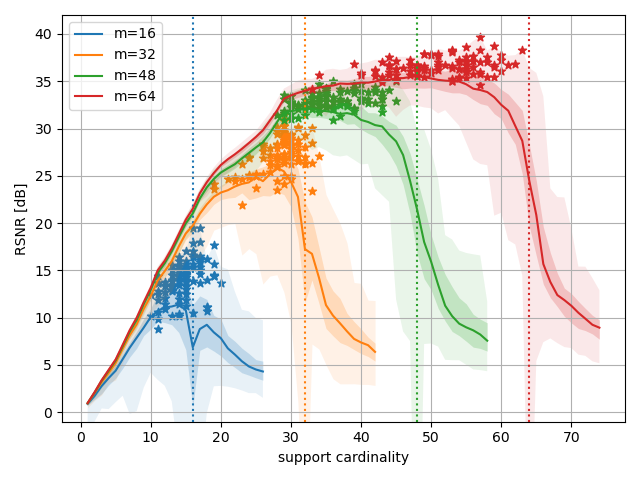

In [19]:
fig, ax = plt.subplots()
for i, m in enumerate(m_list):
    color = f'C{i}'
    _rsnr = rsnr.xs(m, level='m', axis=1).dropna().T
    ax.plot(_rsnr.median(), label=f'm={m:2d}', color=color)
    ax.fill_between(_rsnr.columns, _rsnr.quantile(.25), _rsnr.quantile(.75), 
                    alpha=0.2, color=color, lw=0)
    ax.fill_between(_rsnr.columns, _rsnr.min(), _rsnr.max(), 
                    alpha=0.1, color=color, lw=0)
    ax.scatter(_rsnr.idxmax(axis=1), _rsnr.max(axis=1), c=color, marker='*')
    ax.axvline(m, color=color, ls=':')
ax.set(xlabel='support cardinality', ylabel='RSNR [dB]', ylim=(-1, 42))
ax.grid()
ax.legend()
fig.tight_layout()

### Experiments

The experiments measure the Resconstruction Signal to Ratio (RSNR) in different settings. Different settings involve:
- data: the amount of noise injected into the synthetic ECG signal
- compressed sensing system: the amount of measurements (`m`), the type of encoder (standard or rakeness-based), and whether the sensing matrix is orthogonalized or not.

In [20]:
# Experiment parameters

# ---- data ----
isnr_list = (25., 35., )  # Intrinsic Signal-to-Noise Ratio

# ---- support ----
method = 'TSOC'  # support identification algorithm

# ---- compressed sensing ----
m_list = (16, 32, 48, 64)  # number of measurements
mode = 'standard'  # CS mode: standard, rakeness
orth = True  # whether orthogonalize sensing matrix or not


The experiments are conducted through the script `compute_rsnr_TSOC.py`. Here we load and visulize the results.

In [21]:
rsnr = []
for isnr in isnr_list:
    folder = os.path.join(
        data_folder, f'seed={ecg_seed}_n={n}_basis={basis}_isnr={isnr}')
    rsnr_path = os.path.join(folder, f'rsnr_method={method}.pkl')
    tmp = pd.read_pickle(rsnr_path)
    tmp = tmp.xs((mode, orth), level=('mode', 'orth'), axis=1)
    tmp = tmp.reindex(columns=m_list, level='m')
    tmp = pd.concat(
        [tmp], axis=1, keys=[isnr], names=['isnr'] + tmp.columns.names)
    rsnr.append(tmp)
rsnr = pd.concat(rsnr, axis=1)

In [22]:
_rsnr = rsnr.stack('seed')
rsnr_med = _rsnr.median()
rsnr_q25 = _rsnr.quantile(.25)
rsnr_q75 = _rsnr.quantile(.75)

rsnr_med.unstack('isnr')

isnr,25.0,35.0
m,,
16,14.652561,16.080222
32,21.433173,27.994477
48,24.432737,32.704066
64,26.786203,35.682475


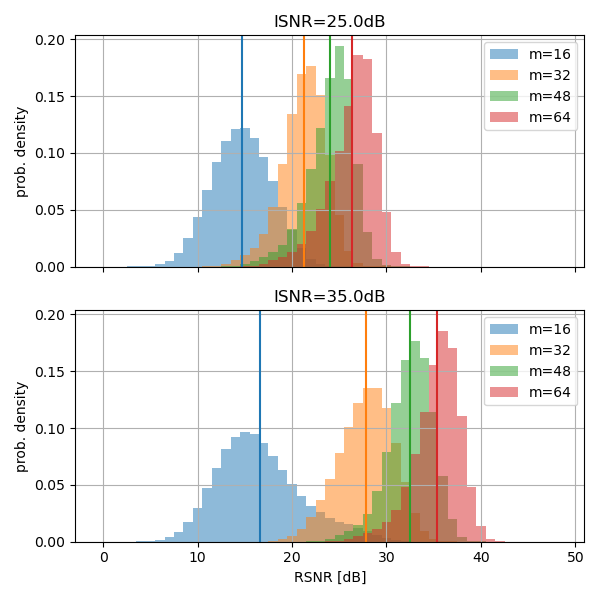

In [23]:
ncols = min(int(np.sqrt(np.floor(len(isnr_list)))), 4)
nrows = len(isnr_list) // ncols

fig, axs = plt.subplots(nrows, ncols, figsize=(6, 3*nrows), 
                        sharex='all', sharey='all', squeeze=False)
ebin_width = 1.
ebin_min = np.round(np.min(rsnr.values)) - ebin_width/2
ebin_max = np.round(np.max(rsnr.values)) + ebin_width/2
ebins = np.arange(ebin_min, ebin_max, ebin_width)
for ax, isnr in zip(axs.flatten(), isnr_list):
    __rsnr = _rsnr.xs(isnr, level='isnr', axis=1)
    for i, m in enumerate(__rsnr.columns.unique('m')):
        color = f'C{i}'
        ax.hist(__rsnr[m], bins=ebins, density=True, 
                alpha=0.5, label=f'm={m}', color=color)
        ax.axvline(__rsnr[m].mean(), color=color)
        # ax.axvline(__rsnr[m].median(), color=color)
    ax.set(title=f'ISNR={isnr}dB')
    ax.grid()
    ax.legend()
for ax in axs[:, 0]: ax.set(ylabel='prob. density')
for ax in axs[-1]: ax.set(xlabel='RSNR [dB]')

fig.tight_layout()


## References


1. <a name="TBCAS2020"></a> M. Mangia, L. Prono, A. Marchioni, F. Pareschi, R. Rovatti and G. Setti, "Deep Neural Oracles for Short-Window Optimized Compressed Sensing of Biosignals," in IEEE Transactions on Biomedical Circuits and Systems, vol. 14, no. 3, pp. 545-557, June 2020, doi: [10.1109/TBCAS.2020.2982824](www.doi.org/10.1109/TBCAS.2020.2982824)
2. <a name="JETCAS2020"></a> L. Prono, M. Mangia, A. Marchioni, F. Pareschi, R. Rovatti and G. Setti, "Deep Neural Oracle With Support Identification in the Compressed Domain," in IEEE Journal on Emerging and Selected Topics in Circuits and Systems, vol. 10, no. 4, pp. 458-468, Dec. 2020, doi: [10.1109/JETCAS.2020.3039731](www.doi.org/10.1109/JETCAS.2020.3039731)
3. <a name="McSharry_TBME2003"></a> P. E. McSharry, G. D. Clifford, L. Tarassenko and L. A. Smith, "A dynamical model for generating synthetic electrocardiogram signals," in IEEE Transactions on Biomedical Engineering, vol. 50, no. 3, pp. 289-294, March 2003, doi: [10.1109/TBME.2003.808805](www.doi.org/10.1109/TBME.2003.808805)
4. <a name="TBCAS2015"></a> F. Pareschi, P. Albertini, G. Frattini, M. Mangia, R. Rovatti and G. Setti, "Hardware-Algorithms Co-Design and Implementation of an Analog-to-Information Converter for Biosignals Based on Compressed Sensing," in IEEE Transactions on Biomedical Circuits and Systems, vol. 10, no. 1, pp. 149-162, Feb. 2016, doi: [10.1109/TBCAS.2015.2444276](www.doi.org/10.1109/TBCAS.2015.2444276)